# Foundations Of AIML
## Session 11
### Experiment 2.1: Fine-tuning pre-trained CNN - Inception v3

We have seen using the pre-trained model as a black box for feature extraction. This gave us a decent accuracy. However, if we have sufficent data we can *tweak* the learned model to extract features specific to our new dataset. Note that, we have 5000 training images which is not sufficient to train a deep model from scratch. But, 5000 might be enough to *tweak* the pre-trained model to be specific to our dataset. We will see what happens when we tweak only a small specific part of the pre-trained model. We will also see how to tweak the entire model. How many layers to tweak depends on amount of available data. Finetuning to specific data, when done properly, is almost always beneficial.

In [ ]:
## NOTE: Read the comments to understand the refining of Inception v3 model

In [2]:
# Importing pytorch packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
# Importing config.py file
import config as cf
from utils import *
from light_cnn import network_9layers   ## Light CNN model with less weights
from data_loader import *
## Importing python packages
import os
import sys
import time
import datetime
import numpy as np
import math
import matplotlib.pyplot as plt

In [3]:
import torchvision.models as models   ## Used for Pretrained PyTorch models

In [5]:
cf.data_dir = 'data/'

## IMFDB data is with 16 classes, Loading atleast 32 images per Batch of Train loader is exhauting memory
## So Test with IIC data which is only 5 classes and use 10 images per batch for training

#img_root = cf.data_dir+'IMFDB_final/'
#train_list_file = cf.data_dir+'IMFDB_train.txt'   #### 5000 images for training
#val_list_file = cf.data_dir+'IMFDB_test.txt'      #### 1095 images for validation

# img_root = "data/IMFDB_final/"
# train_list_file = "data/IMFDB_train.txt"        #### 5000 images for training
# val_list_file = "data/IMFDB_test.txt"           #### 1095 images for validation

img_root = "data/IIC/"
train_list_file = "data/IIC_train.txt"
val_list_file = "data/IIC_test.txt"
print(img_root,train_list_file)

train_image_list = [line.rstrip('\n') for line in open(train_list_file)]
val_image_list = [line.rstrip('\n') for line in open(val_list_file)]

print (len(train_image_list), len(val_image_list))

## Define classes for IIC dataset
#classes = ['AamairKhan', 'Rimisen', 'Kajol', 'KareenaKapoor','RishiKapoor', 'AmrishPuri', 'AnilKapoor', 'AnupamKher', 'BomanIrani', 'HrithikRoshan', 'KajalAgarwal', 'KatrinaKaif', 'Madhavan', 'MadhuriDixit', 'Umashri', 'Trisha']
classes = ['baba_ramdev', 'biswa',  'dhinchak_pooja',  'khali',  'priya_prakash']

data/IIC/ data/IIC_train.txt
1003 50


In [7]:
traindir = "data/IIC_Inception/train"
valdir = "data/IIC_Inception/val"

## For PyTorch Pretrained models Input size is expected as [224,224] except for inception v3 which is [229,229]
## Standard Normalization expetced for Pretrained Pytorch models
## https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#sphx-glr-beginner-transfer-learning-tutorial-py
## https://discuss.pytorch.org/t/imagenet-example-with-inception-v3/1691

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
print(traindir)
trainloader = torch.utils.data.DataLoader(
        datasets.ImageFolder(traindir, transforms.Compose([
            #transforms.RandomSizedCrop(224),
            #transforms.RandomHorizontalFlip(),
            transforms.Resize([299,299]),
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=10, shuffle=True,
        num_workers=0, pin_memory=False)

testloader = torch.utils.data.DataLoader(
        datasets.ImageFolder(valdir, transforms.Compose([
            transforms.Resize([299,299]),
            #transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=5, shuffle=False,
        num_workers=0, pin_memory=False)

data/IIC_Inception/train


In [8]:
# Checking for GPU instance
use_cuda = torch.cuda.is_available()
#Intilizaing the accuracy value as zero
best_acc = 0
num_classes = 5   ## For IIC data
#num_classes = 16  ## For IMFDB data

print(use_cuda)

False


### Net surgery
the original pre-trained model has the last layer (fc2) for 79077 classes but we want to have last layer for only 16 classes.
We chop-off the fc2 with 79077 classes and *implant* a new classifier (the MLP model we used in the previous experiment) which predicts 16 classes. Note that we could also implant a single FC layer with 16 classes (instead of a 3 layer MLP).

In [9]:
inception = models.inception_v3(pretrained=True,transform_input=True)
print(inception)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [10]:
## starting the surgery - Remove FC layer for the full model (not Aux model) and define own classifier
## This is not very efficient for Inception v3 model. Check below for training by removing all the FC layers (both full model and Aux model)

layers_to_remove = ['fc']
for layers_ in layers_to_remove:        
    del(inception._modules[layers_])
    
#### old fc removed.

classifier = nn.Sequential(nn.Linear(2048, 512), nn.BatchNorm1d(512), nn.ReLU(),
                           nn.Linear(512, 32), nn.BatchNorm1d(32), nn.ReLU(),
                           nn.Linear(32, num_classes))

### implanting a new fc2
inception.fc = classifier
if use_cuda:
    inception.cuda()

## Define the layers for which to update the gradients by optimizer
## Check the other method where we also set requires_grad=True to only such parameters where we want to even calulate the gradient
## layers_to_finetune and settting optimizer to this will gaurantee that only these layers are updated with gradients, however gradients are calculated for all parameters which consumes more memory and time
layers_to_finetune = [{'params': inception.fc.parameters()}]

In [11]:
## Check if the new FC layers are updated in the model
print(inception)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [12]:
### Intiliazing the loss
criterion = nn.CrossEntropyLoss()

In [17]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    inception.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        #print(len(inputs), targets)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        outputs = inception(inputs)      ### notice that the pre-trained network has an implant classifier which directly outputs the 16 class prediction scores
        
        ## some issue with outputs...what does inception return?
        ## Inception V3 returns two outputs when set to "Training"- One for actual model and other for Auxillary model
        ## Loss need to be computed for both models and Total loss need to be BP'ed
        ## https://discuss.pytorch.org/t/imagenet-example-with-inception-v3/1691/3
        
        #print(outputs)
        #size_ = outputs.size()
        #print(len(outputs))
        #outputs_ = outputs.view(size_[0], num_classes)
        outputs_0 = outputs[0]
        outputs_1 = outputs[1]
        #print(outputs_0)
        #print(outputs_1)
        loss_0 = criterion(outputs_0, targets)
        loss_1 = criterion(outputs_1, targets)
        #print(loss_0, loss_1)
        loss = loss_0 + loss_1
        #print(loss)
        loss.backward()
        optimizer.step()

        train_loss += loss.data[0]
        _, predicted = torch.max(outputs_0.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        
        if batch_idx%10 == 0 or batch_idx == len(trainloader)-1:
            progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
        
    train_loss_file.write('%d %.3f %.3f\n' %(epoch, train_loss/len(trainloader), 100.*correct/total))



In [55]:
def test(epoch):
    global best_acc
    inception.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        
        ## Inception V3 returns only one outputs when set to "eval"- so outputs is treated differently for testing/evaluation
        outputs = inception(inputs)
        #print(outputs)
        #outputs_0 = outputs[0]
        size_ = outputs.size()
        outputs_ = outputs.view(size_[0], num_classes)
        loss = criterion(outputs_, targets)

        test_loss += loss.data[0]
        _, predicted = torch.max(outputs_.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        
        if batch_idx%5 == 0 or batch_idx == len(testloader)-1:
            progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
        
    print ('val_loss: ',  test_loss/len(testloader), 'accuracy: ', 100.0*correct/total)
    val_loss_file.write('%d %.3f %.3f\n' %(epoch,  test_loss/len(testloader), 100.*correct/total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': classifier,
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir(cf.data_dir+'checkpoint'):
            os.mkdir(cf.data_dir+'checkpoint')
        torch.save(state, cf.data_dir+'checkpoint/checkpoint_inception_all_ckpt.t7')
        best_acc = acc
    
    return test_loss/len(testloader)

In [25]:
experiment = 'inception_finetune_fc_IIC/'
#train_loss_file = open(cf.data_dir+experiment+"/train_loss.txt", "w", 0)
#val_loss_file = open(cf.data_dir+experiment+"/val_loss.txt", "w", 0)
train_loss_file = open("data/inception_finetune_fc_IIC/train_loss.txt", "w+")
val_loss_file = open("data/inception_finetune_fc_IIC/val_loss.txt", "w+")

In [27]:
optimizer = optim.Adam(layers_to_finetune, lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)   #### dynamic LR scheduler
for epoch in range(0, 10):
    train(epoch)
    test_loss = test(epoch)
    scheduler.step(test_loss)
    
train_loss_file.close()
val_loss_file.close()


Epoch: 0


C:\Users\vgopired\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


 [==================================>] | Loss: 9.278 | Acc: 63.000% (635/1003)  101/101 


C:\Users\vgopired\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([[ 1.3281, -0.8079, -0.4068, -0.0705, -0.7599],
        [ 1.9623, -1.0684, -0.9724,  0.1779, -1.1739],
        [ 2.4755, -1.3137, -1.0497, -0.0565, -1.4196],
        [ 1.3999, -0.5170, -0.5496,  0.0820, -0.7635],
        [ 1.7188, -0.7831, -0.5793, -0.1362, -0.8382]])


C:\Users\vgopired\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


tensor([[ 1.4347, -0.4537, -0.8952,  0.3561, -1.0565],
        [ 1.7532, -0.8908, -0.6896, -0.0019, -1.0352],
        [ 0.2905, -0.5779,  0.2071, -0.2968, -0.3032],
        [ 1.9243, -0.8738, -0.6672, -0.1363, -1.0702],
        [ 1.9047, -0.9666, -0.7373, -0.0723, -1.0723]])
tensor([[-0.0645,  0.8602, -0.6497,  0.3188, -0.5023],
        [-0.7104,  0.0978, -0.3252,  0.6691, -0.3279],
        [ 0.1875,  0.2973, -0.1487, -0.0491, -0.2422],
        [-0.6691,  0.6734, -0.8781,  1.1787, -0.8602],
        [-1.1909,  0.9887, -0.7875,  1.3192, -0.8296]])
tensor([[-0.7468,  1.3098, -0.5443,  0.4047, -0.4702],
        [-1.2978,  1.7331, -0.6545,  0.6491, -0.7830],
        [-0.3781,  1.4632, -0.5734,  0.0146, -0.5533],
        [-0.8426,  1.0804,  0.0290, -0.2068, -0.2327],
        [-1.3699,  1.9825, -0.9987,  0.6019, -0.5505]])
tensor([[-1.3569, -0.5721,  1.5778, -0.6979,  0.0989],
        [-1.5405, -0.6032,  1.7402, -0.7312,  0.1706],
        [-0.3664, -0.2120,  0.9629, -0.3202, -0.1993],
       

tensor([[-1.2978, -1.5760, -0.0160, -1.3042,  1.3003],
        [-2.1385, -1.0937,  0.3777, -1.2407,  1.3980],
        [-0.9242, -1.3910,  0.8600, -1.0298,  0.5422],
        [ 0.6240, -0.4552, -0.2269, -0.2553, -0.3669],
        [-1.0218,  1.5136, -0.4960, -0.4468, -0.1656]])
 [===============================>...] | Loss: 0.563 | Acc: 82.000% (41/50)     10/10 
val_loss:  tensor(0.5630) accuracy:  tensor(82)

Epoch: 3
 [==================================>] | Loss: 9.075 | Acc: 68.000% (685/1003)  101/101 
tensor([[ 1.7159, -1.3996, -0.7231, -0.2007, -1.0605],
        [ 2.7520, -1.5924, -1.4785, -0.0891, -1.7131],
        [ 3.6821, -1.9548, -1.8899, -0.3244, -2.1601],
        [ 2.1044, -0.9390, -1.3904,  0.2766, -1.6494],
        [ 2.4447, -1.2883, -1.0230, -0.4385, -1.3021]])
tensor([[ 0.9411, -0.5421, -1.5438,  0.9984, -1.6250], Acc: 100.000% (5/5)      1/10 
        [ 2.3403, -1.1721, -1.0233, -0.3098, -1.5789],
        [ 0.7557, -1.4014,  0.1144, -0.6985, -0.5122],
        [ 2.2203, 

tensor([[-2.1140,  0.8659, -0.5855,  1.0629, -0.7799], Acc: 93.000% (28/30)     6/10 
        [-1.0647, -0.5279, -0.6128,  1.3391, -0.8831],
        [-1.7257,  1.0302, -0.8804,  1.1631, -1.0858],
        [-2.1941, -0.1523, -1.5392,  2.6879, -1.8710],
        [-1.9049, -0.6713, -1.2629,  1.2351, -0.1407]])
tensor([[-2.2553, -0.2562, -1.2137,  2.5597, -1.8725],
        [-1.2564, -0.3512, -1.1305,  1.8912, -1.3457],
        [-1.6220,  0.4323, -0.9653,  1.7945, -1.4426],
        [-2.1012,  1.3255, -0.4283,  1.7023, -2.4930],
        [-2.9344, -0.1981, -0.1967,  1.4000, -0.5088]])
tensor([[-2.2918, -0.7417,  0.6881, -1.6951,  1.3469],
        [-2.2242, -1.2374,  1.1795, -0.7101,  0.5145],
        [-2.6349,  0.7058,  0.1436, -0.4175,  0.2802],
        [-2.2776, -1.6205,  0.3685, -1.4849,  1.6653],
        [-0.4204, -0.5822,  0.3739, -0.4914,  0.4145]])
tensor([[-1.2059, -1.8553,  0.1340, -1.7108,  1.3978],
        [-2.0879, -1.6646,  0.3521, -1.7115,  1.6529],
        [-0.8812, -0.8465,  0.5

tensor([[-1.6636,  1.4304, -0.0173,  0.2838, -1.3275],
        [-2.6533,  2.1032, -0.2465, -0.2075, -0.9989],
        [ 0.1311,  1.4740, -1.1917,  0.0276, -1.4840],
        [-1.8185,  0.6285,  0.0873, -1.0335,  0.3372],
        [-2.1453,  1.8978, -0.9268,  0.4488, -1.0301]])
tensor([[-3.1219, -1.5713,  3.0088, -1.7271, -0.3490],
        [-1.9664, -0.9783,  2.3085, -1.1819, -0.6709],
        [-0.9009, -0.5501,  1.4422, -0.7187, -0.7662],
        [-3.1578, -0.9837,  2.9243, -1.5182, -0.4847],
        [-2.6687, -1.7335,  3.1148, -1.7537, -0.4639]])
tensor([[-3.6736, -0.7960,  3.4047, -1.7354, -0.6317],
        [-2.8318, -0.5763,  2.8490, -0.9049, -1.1389],
        [-2.4057, -0.3242,  1.9227, -1.4985, -0.1081],
        [-2.6842, -1.5684,  1.8682, -2.4757,  0.9490],
        [-2.4072, -0.5913,  2.5415, -0.8058, -1.1814]])
tensor([[-2.2226,  0.8387, -0.3103,  0.9580, -1.3381], Acc: 93.000% (28/30)     6/10 
        [-1.0389, -0.4829, -0.3058,  0.8679, -0.6594],
        [-1.1151,  1.3741, -1.0

10 10


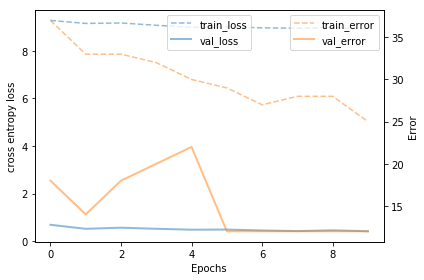

In [28]:
training_curves(cf.data_dir+experiment)

In [29]:
## After training we load the model that performed the best on validation data (avoid picking overfitted model)
classifier = torch.load(cf.data_dir+'checkpoint/checkpoint_inception_ckpt.t7')['net'].eval()

In [30]:
def eval():
    inception.eval()
    
    testloader = torch.utils.data.DataLoader(
        datasets.ImageFolder(valdir, transforms.Compose([
            transforms.Resize([299,299]),
            #transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=1, shuffle=False,
        num_workers=0, pin_memory=False)
    
    correct = 0
    total = 0
    conf_mat = np.zeros((num_classes, num_classes))
    total_ = np.zeros((num_classes))
    wrong_predictions = []
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        outputs = inception(inputs)
        size_ = outputs.size()
        outputs_ = outputs.view(size_[0], num_classes)
        _, predicted = torch.max(outputs_.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        prediction = predicted.cpu().numpy()[0]
        targets = targets.data.cpu().numpy()[0]
        total_[targets] +=1
        conf_mat[predicted, targets] +=1
        
        if prediction != targets:
            wrong_predictions += [[inputs, prediction, targets]]
        
    for k in range(num_classes):
        conf_mat[:,k] /= total_[k]
    return conf_mat, 100.*correct/total, wrong_predictions
    

In [31]:
conf, acc, wrong_predictions = eval()
print ('Accuracy:', acc, '%')

C:\Users\vgopired\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Accuracy: tensor(88) %


Whoa!! :o Fine-tuning improved the accuracy by more than 15%

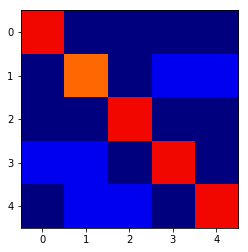

In [32]:
plt.imshow(conf, cmap='jet', vmin=0, vmax = 1)
plt.show()

baba_ramdev confused with khali


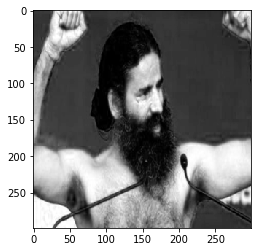

In [33]:
for w in wrong_predictions[::10]:
    print (classes[w[2]], 'confused with', classes[w[1]])
    plt.imshow(w[0][0][0].data.cpu().numpy(), cmap='gray')
    plt.show()

# Now let's try fine-tuning both the FC layers (full model and Aux model) in the network
## This will ensure that Loss computed is much more accurate during training for Aux model
### Use the below model to refine Inception V3 - This is accurate than the above fine tuning of only one FC layer

In [256]:
inception = models.inception_v3(pretrained=True,transform_input=True)
#print(inception) - To check the layers of the model

In [257]:
## Two ways to get the weights - 

#print(inception._modules['fc'].weight)
#print(inception._modules['Mixed_7c'].branch_pool.conv.weight)

### To print weights and grad's
#param = list(inception.parameters())
#print(param[-3].data)
#print(param[-1].grad.data)

In [258]:
##Define 2 classifiers to replace the Fully connected layers of Inception V3 model - one for actual model and other for Aux model
classifier_Aux = nn.Sequential(nn.Linear(768, 192), nn.BatchNorm1d(192), nn.ReLU(),
                           nn.Linear(192, 48), nn.BatchNorm1d(48), nn.ReLU(),
                           nn.Linear(48, num_classes))
classifier = nn.Sequential(nn.Linear(2048, 512), nn.BatchNorm1d(512), nn.ReLU(),
                           nn.Linear(512, 32), nn.BatchNorm1d(32), nn.ReLU(),
                           nn.Linear(32, num_classes))

In [259]:
## Replace the FC layers
inception.AuxLogits.fc = classifier_Aux
inception.fc = classifier
if use_cuda:
    inception.cuda()
#print(inception.AuxLogits)
#print(inception) # Print the re-defined model

In [260]:
## Freeze all parameters/weights first - this will ensure that loss.backward() (BP) doesn't calculate the gradients
for param in inception.parameters():
    param.requires_grad = False

In [261]:
## Set the requires_grad to True to only the layers for which we want BP to caclulate gradients
for param in inception.AuxLogits.fc.parameters():
    param.requires_grad = True
for param in inception.fc.parameters():
    param.requires_grad = True
    
## Define the layers for which to update the gradients by optimizer
layers_to_finetune = [{'params': inception.AuxLogits.fc.parameters()}, 
                      {'params': inception.fc.parameters()}]

   

In [262]:
## Uncomment this to check which layer parametres/weights will be updated
#for param in inception.parameters():
    #print(param.requires_grad)  ## Make sure that only required layers are Back propgated with gradients

In [263]:
experiment = 'inception_finetune_all_IIC/'
train_loss_file = open(cf.data_dir+experiment+"train_loss.txt", "w+")
val_loss_file = open(cf.data_dir+experiment+"val_loss.txt", "w+")

In [264]:
best_acc = 0
optimizer = optim.Adam(layers_to_finetune, lr=0.001)  ## Set optimizer to update only te layers we want to update weights
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)   #### dynamic LR scheduler


In [265]:
## Run the training 
for epoch in range(0, 30):
    train(epoch)
    test_loss = test(epoch)
    scheduler.step(test_loss)
    
train_loss_file.close()
val_loss_file.close()


Epoch: 0


C:\Users\vgopired\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


 [==================================>] | Loss: 2.591 | Acc: 48.000% (487/1003)  101/101 


C:\Users\vgopired\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([[ 0.9317, -0.1433, -0.1202, -0.1178, -0.2580],
        [ 0.8281, -0.1876, -0.1792,  0.0402, -0.2138],
        [ 1.8895, -0.4661, -0.7000, -0.1897, -0.8398],
        [ 0.8026, -0.1385, -0.4144, -0.0228, -0.4769],
        [ 1.0898, -0.3131, -0.3904, -0.3773, -0.4077]])


C:\Users\vgopired\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


tensor([[ 0.7664,  0.0954, -0.2029, -0.0228, -0.3317],
        [ 0.9900, -0.2082, -0.0551, -0.1624, -0.3717],
        [ 0.8251, -0.3124,  0.0900, -0.3405, -0.2017],
        [ 1.0151, -0.1330, -0.3505, -0.2192, -0.3471],
        [ 1.4272, -0.2444, -0.4145, -0.1813, -0.6044]])
tensor([[ 0.7878,  0.2776, -0.5651,  0.2539, -0.6673],
        [-0.3634,  0.4206,  0.2598,  0.4097, -0.1941],
        [ 0.1455, -0.0013,  0.1467,  0.1137,  0.0805],
        [ 0.1841,  0.8193, -0.4048,  1.3087, -0.6301],
        [-0.4901,  0.5761,  0.2194,  0.7840, -0.4428]])
tensor([[-0.1810,  0.7919,  0.1580,  0.0753,  0.4726],
        [ 0.0302,  1.0029, -0.2341,  0.6762, -0.7193],
        [ 0.4048,  0.5397, -0.2984, -0.0478, -0.2612],
        [-0.1902,  0.5498,  0.2393,  0.0221,  0.4293],
        [ 0.0277,  1.1506, -0.2534,  0.7052, -0.3634]])
tensor([[-1.0439, -0.7050,  1.4888, -0.2389, -0.0499],
        [-0.8993, -0.3238,  1.3053, -0.3701,  0.6827],
        [-0.4792, -0.2400,  0.9491, -0.1751, -0.2843],
       

tensor([[-1.7249, -0.2743,  0.9642, -0.8589,  2.5411],
        [-2.2306, -0.0689,  1.0114, -0.7027,  2.9024],
        [-0.9121, -0.1745,  0.7932, -0.4339,  1.1846],
        [-0.9353, -0.1620,  0.9539, -0.1978,  0.6723],
        [-1.2177,  2.0409, -0.1589,  0.1470, -0.0502]])
 [===============================>...] | Loss: 0.591 | Acc: 82.000% (41/50)     10/10 
val_loss:  tensor(0.5912) accuracy:  tensor(82)
Saving..

Epoch: 3
 [==================================>] | Loss: 1.467 | Acc: 69.000% (694/1003)  101/101 
tensor([[ 1.5638, -0.6611, -0.7063,  0.2968, -0.9638],
        [ 3.1874, -1.4321, -1.3200,  0.0287, -1.6988],
        [ 4.3322, -1.9789, -1.6889, -0.4104, -2.2772],
        [ 1.7705, -0.6492, -1.2403,  0.7200, -1.2509],
        [ 2.2431, -1.1955, -0.6679, -0.5450, -0.9873]])
tensor([[ 1.6271, -0.5093, -0.7469,  0.2328, -0.9236], Acc: 100.000% (5/5)      1/10 
        [ 2.0279, -0.8072, -0.5620, -0.2811, -0.9943],
        [ 0.5333, -0.7867,  0.3221, -0.7117,  0.1991],
        [

tensor([[-1.2772,  0.7166, -0.6395,  1.9181, -0.5964], Acc: 90.000% (27/30)     6/10 
        [-0.9192,  0.1545, -0.5143,  1.8341,  0.0299],
        [-0.5735,  1.3605, -1.4213,  1.9840, -1.6715],
        [ 0.0404,  0.0778, -1.0625,  1.9265, -1.3018],
        [-1.2976, -0.3747, -0.3269,  2.7648, -0.6404]])
tensor([[-1.0546,  0.7192, -1.1252,  3.0817, -2.0389],
        [-1.2293,  0.3574, -0.8434,  3.0089, -1.4542],
        [-0.9035,  0.5057, -0.4820,  1.7178, -0.8371],
        [-1.9462,  0.7692, -0.2841,  2.5027, -2.1158],
        [-1.3786,  0.1006, -0.1476,  1.8490, -0.8220]])
tensor([[-2.3896,  0.2824,  1.0219, -1.3121,  2.8904],
        [-1.5839,  0.0145,  1.0877, -0.4144,  0.7268],
        [-1.6218,  1.6682,  0.3821, -0.4735,  0.5602],
        [-1.8318, -0.6179,  0.5853, -0.4554,  2.4997],
        [-0.4435, -0.2345,  0.5938, -0.7076,  0.6343]])
tensor([[-1.3660, -0.8982,  0.4056, -1.4435,  2.6828],
        [-1.6309, -0.8203,  0.7993, -0.9893,  2.5372],
        [-0.8464, -0.4152,  0.3

tensor([[-1.7991,  2.1745, -0.4421,  0.3550, -0.9966],
        [-1.6210,  3.2078, -1.1100,  0.1667, -1.7246],
        [-0.8051,  2.4917, -0.9241, -0.6067, -1.1472],
        [-2.4006,  2.5848,  0.1668, -0.6576,  0.3489],
        [-1.9228,  1.9521, -0.5309,  0.8227, -0.8928]])
tensor([[-2.3307, -1.6560,  2.8039, -1.7720,  1.0622],
        [-1.6060, -1.4156,  2.4110, -1.3710, -0.1009],
        [-1.1471, -0.7424,  1.5666, -0.7536, -0.0222],
        [-2.1187, -0.8358,  2.6839, -1.4464,  0.1163],
        [-1.0446, -0.9474,  1.9109, -1.7921,  0.8413]])
tensor([[-2.1810, -0.3000,  3.1729, -1.9714, -0.7159],
        [-2.3216, -1.0345,  2.6479, -0.9403, -0.4917],
        [-2.1552, -0.4817,  2.0214, -0.8294,  0.2472],
        [-2.4712, -0.7007,  1.8165, -1.9051,  2.1095],
        [-2.7636, -0.8775,  2.6429, -0.8234, -0.0913]])
tensor([[-1.6226,  1.1920, -0.6337,  1.6941, -1.7632], Acc: 93.000% (28/30)     6/10 
        [-0.8965,  0.0121, -0.4685,  1.9399, -0.8077],
        [-1.1248,  2.0258, -1.5

 [==================================>] | Loss: 0.924 | Acc: 76.000% (764/1003)  101/101 
tensor([[ 3.1315, -1.8850, -1.2327, -0.6983, -1.2044],
        [ 4.1798, -1.9034, -1.8849, -0.2499, -2.2224],
        [ 5.6582, -2.8123, -2.1608, -1.3251, -2.7790],
        [ 2.6695, -1.2517, -1.5374,  0.3106, -1.3587],
        [ 3.3365, -2.3122, -0.5754, -1.9338, -1.0432]])
tensor([[ 2.6763, -0.8157, -1.8865,  0.0325, -1.6474], Acc: 100.000% (5/5)      1/10 
        [ 2.9422, -1.3690, -1.1059, -0.4919, -1.5412],
        [ 1.7904, -1.7979,  0.2749, -1.5802, -0.2761],
        [ 4.6580, -2.0492, -1.5234, -1.4860, -2.4628],
        [ 3.8770, -1.7405, -1.4934, -1.3071, -2.0045]])
tensor([[ 0.3913,  1.5894, -2.2006,  0.5049, -1.8274],
        [-3.1024, -0.3616,  0.8849,  1.4516,  0.0764],
        [-1.1386,  0.5288,  0.7037, -0.6465, -0.1990],
        [-2.4020,  2.5203, -1.3239,  1.1220, -0.1665],
        [-2.4031,  2.2829, -0.3308,  0.8447, -1.3072]])
tensor([[-1.4598,  1.8237, -0.3915,  0.1856, -0.9474

tensor([[-2.3776,  1.0704, -1.0140,  3.3904, -2.9550],
        [-2.6721,  0.6866, -1.2455,  3.8841, -2.1455],
        [-1.8890,  1.3754, -1.3793,  2.4102, -1.4765],
        [-1.7125,  0.7284, -0.1741,  1.8292, -2.2100],
        [-2.6288,  0.4994, -0.2712,  2.4320, -1.5474]])
tensor([[-4.5126,  0.9770,  1.5680, -1.8464,  2.9010],
        [-3.1699, -0.8016,  1.9637, -0.3576,  0.7464],
        [-4.0055,  1.9497,  0.7219, -0.2270,  0.7568],
        [-2.0974, -1.2584,  0.6759, -0.8440,  2.6375],
        [-0.8354, -0.1962,  0.4388, -1.0373,  0.8502]])
tensor([[-2.1732, -1.0046,  0.4937, -1.7438,  2.7826],
        [-2.4889, -1.4714,  0.9800, -1.3615,  2.9490],
        [-1.7452, -0.1117,  0.8878, -0.6485,  0.9436],
        [-1.4220,  0.8760,  0.2453, -0.6076,  0.2741],
        [-2.4992,  1.3797, -0.4678, -0.4064,  1.4785]])
 [===============================>...] | Loss: 0.350 | Acc: 90.000% (45/50)     10/10 
val_loss:  tensor(0.3501) accuracy:  tensor(90)

Epoch: 14
 [========================

tensor([[-3.0699, -1.6927,  3.1616, -1.8234,  0.5526],
        [-3.3401, -1.1380,  3.4770, -1.9793, -0.0557],
        [-2.4349, -0.4176,  2.6352, -1.4918, -0.4392],
        [-4.2320, -0.4934,  3.2970, -1.8725,  0.8284],
        [-2.0248, -0.9206,  2.4468, -2.1177,  0.6381]])
tensor([[-2.8976, -0.3360,  3.5428, -2.2464, -1.2057],
        [-3.2930, -1.1632,  3.6014, -1.4536, -1.1782],
        [-3.2644, -0.5233,  3.0614, -1.6107, -0.2592],
        [-4.4187, -0.2742,  3.1769, -3.1571,  1.9808],
        [-4.1644, -0.7118,  3.7603, -1.7158, -0.5181]])
tensor([[-2.3345,  1.4478, -0.4535,  1.7786, -2.1399], Acc: 93.000% (28/30)     6/10 
        [-1.0884, -0.0320, -0.4765,  1.8073, -0.5391],
        [-2.3242,  2.3015, -1.1557,  1.8382, -2.2042],
        [-1.8509,  0.6108, -1.3533,  3.0449, -1.7135],
        [-1.5285,  0.3335, -1.3377,  2.9742, -1.3210]])
tensor([[-2.1715,  1.1042, -1.3648,  3.5253, -3.1716],
        [-2.0159,  0.3238, -1.1517,  3.5187, -2.5180],
        [-1.4462,  0.4656, -1.1

tensor([[ 2.9918, -0.9436, -2.7520,  0.4770, -1.6686], Acc: 100.000% (5/5)      1/10 
        [ 3.2824, -1.0374, -1.0725, -0.9590, -2.1762],
        [ 1.4618, -1.7182,  0.5255, -2.2488, -0.0418],
        [ 3.5621, -1.0896, -1.1776, -1.4740, -2.1487],
        [ 3.5390, -1.2592, -1.5234, -1.2904, -1.9176]])
tensor([[-0.9362,  2.4910, -1.7692,  0.4603, -1.8409],
        [-4.0259,  0.5726,  1.0733,  1.2179, -0.4032],
        [-1.4826,  0.4655,  1.2461, -1.0580, -0.3185],
        [-3.1058,  3.0045, -2.0584,  1.7838, -0.4895],
        [-3.5783,  2.8864, -0.2370,  0.7967, -1.3366]])
tensor([[-2.3205,  2.5964, -0.3813, -0.2379, -1.3866],
        [-2.8892,  3.4185, -0.4313, -0.1003, -1.9113],
        [-1.1063,  2.8371, -0.9664, -0.9387, -2.4692],
        [-2.3090,  2.3449,  0.3503, -1.6948, -0.5298],
        [-1.9698,  2.3584, -1.1357,  0.8258, -1.7569]])
tensor([[-3.4499, -1.6952,  3.1092, -1.7953,  1.0815],
        [-2.4912, -1.4642,  2.8557, -1.8060,  0.2123],
        [-2.2062, -0.5442,  2.3

tensor([[-2.8476, -1.3569,  1.5480, -2.4473,  2.9905],
        [-2.5755, -1.1730,  1.7422, -0.8831,  1.1848],
        [-4.2740,  1.6225,  1.0992, -0.4082,  0.1856],
        [-2.1408, -2.2530,  0.9604, -1.6499,  2.8622],
        [-0.8139, -0.8533,  0.2489, -0.5161,  1.0846]])
tensor([[-1.1907, -3.0456,  0.3419, -2.4636,  3.1746],
        [-2.0037, -2.8002,  0.9955, -1.3337,  2.7688],
        [-1.2391, -0.7600,  0.6915, -0.5568,  0.9287],
        [-0.3299, -0.4326, -0.7236, -0.1785,  0.9272],
        [-2.9684,  1.5676, -0.5015, -0.1089,  0.9961]])
 [===============================>...] | Loss: 0.361 | Acc: 86.000% (43/50)     10/10 
val_loss:  tensor(0.3610) accuracy:  tensor(86)

Epoch: 22
 [==================================>] | Loss: 0.699 | Acc: 77.000% (777/1003)  101/101 
tensor([[ 1.1914, -1.5567, -1.2247,  0.7612, -0.1021],
        [ 3.5826, -1.2982, -3.0302,  1.0686, -2.2833],
        [ 4.9541, -2.0277, -3.0625, -0.5082, -2.3566],
        [ 1.6502, -0.6807, -1.9950,  1.1056, -1.

tensor([[-3.0249, -0.2366,  3.5433, -2.2782, -1.2237],
        [-3.0343, -1.2823,  3.2291, -0.9810, -1.1759],
        [-3.2894, -0.2184,  2.5542, -1.1394, -0.0218],
        [-4.1572, -0.4969,  2.6736, -3.3666,  2.7654],
        [-3.5699, -0.5356,  2.9888, -0.9347, -0.8239]])
tensor([[-2.4897,  1.7119, -1.4344,  2.3409, -1.4937], Acc: 90.000% (27/30)     6/10 
        [-1.3519, -0.3183, -0.8044,  2.4635, -0.1182],
        [-2.5868,  2.2752, -1.3625,  2.2215, -2.1141],
        [-1.2348,  0.3474, -1.5220,  2.8890, -1.8468],
        [-1.2526, -0.2397, -1.6081,  3.2541, -1.1574]])
tensor([[-1.7563,  1.0131, -1.6069,  3.4253, -2.7935],
        [-1.8938,  0.1917, -1.4387,  3.9709, -3.2136],
        [-2.4276,  0.6991, -1.4180,  3.4176, -1.8438],
        [-2.0708,  0.8449, -0.7341,  2.9046, -3.1681],
        [-3.3618,  0.5313, -0.8419,  3.1345, -1.0656]])
tensor([[-3.6043, -0.1160,  1.6593, -2.8218,  2.9687],
        [-2.6661, -0.7904,  1.2958, -0.4438,  1.4268],
        [-4.6602,  2.2404,  0.6

tensor([[ 2.8131, -0.7919, -3.4093,  1.6728, -2.2914], Acc: 100.000% (5/5)      1/10 
        [ 3.5346, -0.9629, -1.5909, -0.6470, -2.4691],
        [ 1.8385, -1.9076,  0.0852, -1.7021, -0.1381],
        [ 4.0914, -1.2138, -1.5373, -1.4147, -2.6000],
        [ 3.9249, -1.5825, -1.6328, -1.1332, -1.9904]])
tensor([[-0.3253,  2.0295, -1.8797,  0.6302, -2.1383],
        [-3.2844,  0.3189,  0.3967,  1.5328,  0.2681],
        [-1.3903,  0.3576,  0.9638, -1.3454, -0.0636],
        [-3.0399,  3.1017, -2.6202,  1.8741, -0.3945],
        [-3.7485,  3.1120, -0.5246,  0.4808, -0.3498]])
tensor([[-2.4247,  2.7594, -1.0649,  0.5622, -1.8060],
        [-2.5153,  3.3113, -1.0342,  0.1886, -1.8262],
        [-1.1108,  3.0509, -1.2812, -0.8756, -2.6746],
        [-2.3342,  2.5288, -0.1517, -1.7047, -0.4566],
        [-2.1317,  2.4602, -1.5834,  1.1456, -1.6802]])
tensor([[-3.3452, -2.0147,  3.1077, -2.3143,  1.7210],
        [-3.1663, -1.2204,  3.1772, -1.8741,  0.2730],
        [-2.0732, -0.6755,  2.1

tensor([[-1.6904, -1.9450,  0.2989, -2.2371,  3.1223],
        [-2.5627, -1.9374,  0.5769, -1.1023,  3.1974],
        [-1.5251, -0.2768,  0.4550, -0.8006,  1.1664],
        [-0.5420, -0.2908, -0.4952, -0.6349,  1.1026],
        [-3.2892,  2.4188, -0.7674, -0.2602,  0.7439]])
 [===============================>...] | Loss: 0.376 | Acc: 90.000% (45/50)     10/10 
val_loss:  tensor(0.3763) accuracy:  tensor(90)
Epoch    29: reducing learning rate of group 0 to 1.5625e-05.
Epoch    29: reducing learning rate of group 1 to 1.5625e-05.


30 30


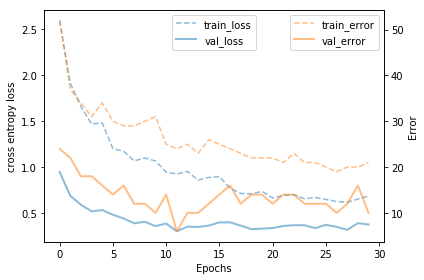

In [266]:
## Plot the Loss and Accuracy curves
training_curves(cf.data_dir+experiment)

In [267]:
## After training we load the model that performed the best on validation data (avoid picking overfitted model)
classifier = torch.load(cf.data_dir+'checkpoint/checkpoint_inception_all_ckpt.t7')['net'].eval()

In [268]:
conf, acc, wrong_predictions = eval()
print ('Accuracy:', acc, '%')

C:\Users\vgopired\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Accuracy: tensor(90) %


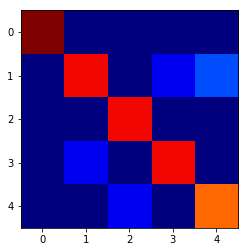

In [269]:
plt.imshow(conf, cmap='jet', vmin=0, vmax = 1)
plt.show()

biswa confused with khali


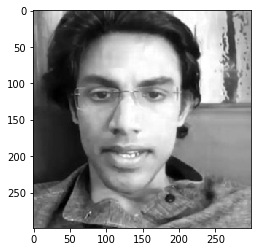

In [270]:
for w in wrong_predictions[::10]:
    print (classes[w[2]], 'confused with', classes[w[1]])
    plt.imshow(w[0][0][0].data.cpu().numpy(), cmap='gray')
    plt.show()

Relying on pre-trained networks we improved the accuracy by more than 20%!!

### Different parts of the model can have different LR. While fine-tuning it is common to set the implanted layers to 10 times higher LR than pre-trained layers. This helps the implanted layers learns faster since it is starting from scratch.